# Description 

This notebook will perform sectorized (range of angle pre-defined) radial profile over a set of files selected using same settings for all images. To get a better description of the algorithm, check the library documentation [in the github repository](https://github.com/JeanBilheux/SectorizedRadialProfile)

# Imports 

In [3]:
from __code import custom_style
custom_style.style()

!pyuic4 ui/ui_radial_profile.ui -o __code/ui_radial_profile.py

from ipywidgets import widgets
from IPython.core.display import display

debug_mode = widgets.Checkbox(
    value=False,
    description='Debug Mode?',
    disabled=False
)
display(debug_mode)

A Jupyter Widget

In [4]:
IPTS = '16212'

from sectorizedradialprofile.calculate_radial_profile import CalculateRadialProfile

try:
    from PyQt4.QtGui import QFileDialog
    from PyQt4 import QtCore, QtGui
    from PyQt4.QtGui import QMainWindow
except ImportError:
    from PyQt5.QtWidgets import QFileDialog
    from PyQt5 import QtCore, QtGui
    from PyQt5.QtWidgets import QApplication
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib notebook

from ipywidgets.widgets import interact
from ipywidgets import widgets
from IPython.core.display import HTML

from pprint import pprint
import pyfits

import datetime
import os
import glob
import shutil
import re
import scipy.ndimage

from plotly.offline import plot, init_notebook_mode, iplot
init_notebook_mode()
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

import pyqtgraph as pg

from IPython.display import display
from IPython import display as display_ipython

from __code import file_handler
from __code import utilities
from __code import gui_widgets

if debug_mode.value:
    ipts = IPTS
else:
    ipts = utilities.get_ipts()
working_dir = utilities.get_working_dir(ipts=ipts)

ImportError: No module named 'sectorizedradialprofile'

In [3]:
%gui qt

# Import images

Select your images (tiff or fits) to work on.

In [4]:
display(HTML('<span style="font-size: 20px; color:blue">Select the images you want to work on!</span>'))
list_images = gui_widgets.gui_fimage(dir=working_dir)
if list_images:
    
    w = widgets.IntProgress()
    w.max = len(list_images)
    display(w)
    
    working_data = []
    for _index, _file in enumerate(list_images):
        _data = np.array(file_handler.load_data(_file))
        _data[_data == np.inf] = np.NaN # removing inf values
        _data[np.isnan(_data)] = 0
        working_data.append(_data)
        w.value = _index + 1
        
    [nbr_files, height, width] = np.shape(working_data)
    working_data = np.squeeze(working_data)
    working_dir = os.path.dirname(list_images[0])

# select parameters

Select **center of circle** and **sector** to use for profile

In [6]:
from __code.ui_radial_profile import Ui_MainWindow as UiMainWindow

rotated_working_data = working_data

class ImageWindow(QMainWindow):
    
    grid_size = 50
    live_data = []
    
    def __init__(self, parent=None, working_data=[]):
        QMainWindow.__init__(self, parent=parent)
        self.ui = UiMainWindow()
        self.ui.setupUi(self)
        self.init_statusbar()
        self.setWindowTitle("Define center and sector of profile")
        
        self.ui.image_view = pg.ImageView()
        self.ui.image_view.ui.roiBtn.hide()
        self.ui.image_view.ui.menuBtn.hide()
        
        bottom_layout = QtGui.QHBoxLayout()

        # file index slider
        label_1 = QtGui.QLabel("File Index")
        self.ui.slider = QtGui.QSlider(QtCore.Qt.Horizontal)
        self.ui.slider.setMaximum(len(list_images)-1)
        self.ui.slider.setMinimum(0)
        self.ui.slider.valueChanged.connect(self.file_index_changed)
        
        # spacer
        spacer = QtGui.QSpacerItem(40, 20, QtGui.QSizePolicy.Expanding, QtGui.QSizePolicy.Minimum)
        
        bottom_layout.addWidget(label_1)
        bottom_layout.addWidget(self.ui.slider)
        bottom_layout.addItem(spacer)

        bottom_widget = QtGui.QWidget()
        bottom_widget.setLayout(bottom_layout)
        
        vertical_layout = QtGui.QVBoxLayout()
        vertical_layout.addWidget(self.ui.image_view)
        vertical_layout.addWidget(bottom_widget)

        self.ui.widget.setLayout(vertical_layout)
        
        self.rotated_working_data = working_data
        self.working_data = working_data
        
        self.display_grid()
        self.init_widgets()
        self.file_index_changed()
        self.init_crosshair()

        
    def init_crosshair(self):
        self.vLine = pg.InfiniteLine(angle=90, movable=True)
        self.hLine = pg.InfiniteLine(angle=0, movable=True)
        self.ui.image_view.addItem(self.vLine, ignoreBounds=True)
        self.ui.image_view.addItem(self.hLine, ignoreBounds=True)
        
    def init_widgets(self):
        self.ui.circle_y.setText(str(np.int(width/2)))
        self.ui.circle_x.setText(str(np.int(height/2)))
        
    def sector_radio_button_changed(self):
        is_full_circle = self.ui.sector_full_circle.isChecked()
        if is_full_circle:
            _status_sector = False
        else:
            _status_sector = True
        self.ui.sector_from_label.setEnabled(_status_sector)
        self.ui.sector_from_value.setEnabled(_status_sector)
        self.ui.sector_from_units.setEnabled(_status_sector)
        self.ui.sector_to_label.setEnabled(_status_sector)
        self.ui.sector_to_value.setEnabled(_status_sector)
        self.ui.sector_to_units.setEnabled(_status_sector)
        
    def init_statusbar(self):
        self.eventProgress = QtGui.QProgressBar(self.ui.statusbar)
        self.eventProgress.setMinimumSize(20, 14)
        self.eventProgress.setMaximumSize(540, 100)
        self.eventProgress.setVisible(False)
        self.ui.statusbar.addPermanentWidget(self.eventProgress)
        
    def get_image_dimension(self, array_image):
        if len(np.shape(array_image)) > 2:
            return np.shape(array_image[0])
        else:
            return np.shape(array_image)
        
    def get_selected_image(self, file_index):

        if len(np.shape(working_data)) > 2:
            return self.working_data[file_index]
        else:
            return self.working_data
        
    def display_grid(self):
        [width, height] = self.get_image_dimension(self.working_data)
        bin_size = self.grid_size
        x0 = 0
        y0 = 0
        
        pos_adj_dict = {}

        nbr_height_bins = np.float(height) / np.float(bin_size)
        real_height = y0 + np.int(nbr_height_bins) * np.int(bin_size)
        
        nbr_width_bins = np.float(width) / np.float(bin_size)
        read_width = x0 + np.int(nbr_width_bins) * np.int(bin_size)
        
        # pos (each matrix is one side of the lines)
        pos = []
        adj = []

        # vertical lines
        x = x0
        index = 0
        while (x <= x0 + width):
            one_edge = [x, y0]
            other_edge = [x, real_height]
            pos.append(one_edge)
            pos.append(other_edge)
            adj.append([index, index+1])
            x += bin_size
            index += 2
            
        # horizontal lines
        y = y0
        while (y <= y0 + height):
            one_edge = [x0, y]
            other_edge = [read_width, y]
            pos.append(one_edge)
            pos.append(other_edge)
            adj.append([index, index+1])
            y += bin_size
            index += 2

        pos = np.array(pos)
        adj = np.array(adj)
        
        line_color = (255, 0, 0, 155, 0.2)
        lines = np.array([line_color for n in np.arange(len(pos))],
                             dtype=[('red',np.ubyte),('green',np.ubyte),
                                    ('blue',np.ubyte),('alpha',np.ubyte),
                                   ('width',float)]) 
    
        line_view_binning = pg.GraphItem()
        self.ui.image_view.addItem(line_view_binning)
        line_view_binning.setData(pos = pos,
                                 adj = adj,
                                 pen = lines,
                                 symbol = None,
                                 pxMode = False)
        
        self.line_view_binning = line_view_binning

    def sector_changed(self):
        pass
    
    def circle_center_changed(self):
        pass
    
    def apply_clicked(self):
        # fixme
        self.close()
        
    def cancel_clicked(self):
        self.close()
    
    def file_index_changed(self):
        file_index = self.ui.slider.value()
        self.ui.image_view.setImage(self.get_selected_image(file_index))
        
    def display_image(self, image):
        self.ui.image_view.setImage(image)
        
    def closeEvent(self, event=None):
        # fixme
        pass
        #global rotation_angle
        #rotation_angle = np.float(str(self.ui.rotation_value.text()))
        
_image = ImageWindow(working_data=working_data)
_image.show()
_image.file_index_changed()

display(HTML('<span style="font-size: 20px; color:blue">Select the center of the circle and the angular sector in the UI that poped up \
(maybe hidden behind this browser!)</span>'))

In [15]:
def select_center(file_index, x0, y0, from_angle, to_angle):
    
    fig, ax = plt.subplots()
    ax.imshow(working_data[file_index])
    
    min_mark_size = 10 #pixels
    
    #show center
    plt.axvline(x=x0)
    plt.axhline(y=y0)
    
    #show symetrical mark on (x0,y0) reference lines to help figure out the right center
    nbr_x_ref_lines = 5
    nbr_y_ref_lines = 5
    
    # calculate the min distance between center and edges
    working_width = np.min([x0, width-x0])
    working_height = np.min([y0, height-y0])
    
    if working_width <= 4 * nbr_x_ref_lines:
        nbr_x_ref_lines = 1
    elif working_height <= 4 * nbr_y_ref_lines:
        nbr_y_ref_lines = 1
    
    #determine the reference lines coordinates
    x_interval = working_width / (nbr_x_ref_lines + 1)
    y_interval = working_height / (nbr_y_ref_lines + 1)
    
    references_lines = []

    #right of x0
    for i in np.arange(nbr_x_ref_lines):
        mark_size = (i+1) * min_mark_size
        point1 = (x0 + (i+1) * x_interval, y0 - mark_size)
        point2 = (x0 + (i+1) * x_interval, y0 + mark_size)
        references_lines.append([point1, point2])
    
    #left of x0
    for i in np.arange(nbr_x_ref_lines):
        mark_size = (i+1) * min_mark_size
        point1 = (x0 - (i+1) * x_interval, y0 - mark_size)
        point2 = (x0 - (i+1) * x_interval, y0 + mark_size)
        references_lines.append([point1, point2])
    
    #top of y0
    for j in np.arange(nbr_y_ref_lines):
        mark_size = (j+1) * min_mark_size
        point1 = (x0 - mark_size, y0 - (j+1) * y_interval)
        point2 = (x0 + mark_size, y0 - (j+1) * y_interval)
        references_lines.append([point1, point2])

    #bottom of y0
    for j in np.arange(nbr_y_ref_lines):
        mark_size = (j+1) * min_mark_size
        point1 = (x0 - mark_size, y0 + (j+1) * y_interval)
        point2 = (x0 + mark_size, y0 + (j+1) * y_interval)
        references_lines.append([point1, point2])

    #calculate list of colors
    basic_color = (1,0,0,1)
    list_color = [basic_color for x in np.arange(len(references_lines))]
    
    lc = mc.LineCollection(references_lines, colors=list_color, linewidths=2)
    ax.add_collection(lc)
    
    #display the radius selected
    ax.add_patch(patches.Wedge((x0, y0), 
                              width,
                              from_angle-90,
                              to_angle-90,
                              alpha=0.7))
    
    center = {'x0': x0,
             'y0': y0}

    angle_range = {'from': from_angle,
                  'to': to_angle}
    
    return {'center': center, 'angle_range': angle_range}
    
preview = interact(select_center,
                    file_index = widgets.IntSlider(min=0,
                                                  max = nbr_files-1,
                                                  value=0,
                                                  description='File Index'),
                  x0 = widgets.IntSlider(min=0,
                                        max=width-1,
                                        value=np.int(width/2),
                                        description = 'x0'),
                  y0 = widgets.IntSlider(min=0,
                                        max=height-1,
                                        value=np.int(height/2),
                                        descrption= 'y0'),
                  from_angle = widgets.IntSlider(min=0,
                                               max=359,
                                               value=0,
                                               descrption='From angle'),
                  to_angle = widgets.IntSlider(min=0,
                                              max=359,
                                              value=45,
                                              descrption='to angle'))

<IPython.core.display.Javascript object>

NameError: name 'mc' is not defined

# Calculate profiles

In [11]:
result = preview.widget.result
center = result['center']
angle_range = result['angle_range']

w = widgets.IntProgress()
w.max = nbr_files-1
display(w)

array_profile = []

for _index in np.arange(nbr_files):
    o_profile = CalculateRadialProfile(
        data=working_data[_index], center=center, angle_range=angle_range)
    o_profile.calculate()
    
    profile = o_profile.radial_profile
    array_profile.append(profile)
    
    w.value = _index+1

# Check results

<IPython.core.display.Javascript object>


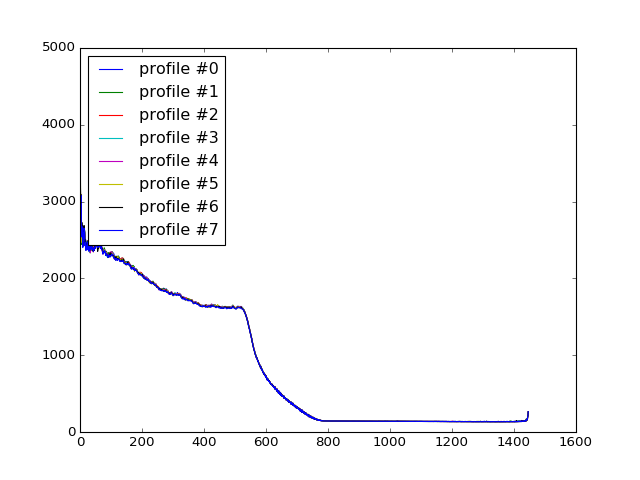

In [12]:
plt.figure(2)
for _index, _profile in enumerate(array_profile):
    plt.plot(_profile, label='profile #{}'.format(_index))
    plt.legend(loc=2)

# Output Result 

Select output folder

In [13]:
output_folder = os.path.dirname(list_data_files[0])
output_folder_name = gui_widgets.gui_dname(dir=output_folder)

for _index, _file in enumerate(list_data_files):

    [input_image_base_name, ext] = os.path.splitext(os.path.basename(_file))
    output_file_name = os.path.join(output_folder_name, input_image_base_name + '_profile_c_x{}_y{}_angle_{}_to_{}.txt'.format(center['x0'], center['y0'],
                                                                                                                         angle_range['from'], angle_range['to']))

    text = []
    text.append("# source image: {}".format(_file))
    text.append("# center [x0, y0]: [{},{}]".format(center['x0'], center['y0']))
    text.append("# angular range from {}degrees to {}degrees".format(angle_range['from'], angle_range['to']))
    text.append('')
    text.append('#pixel_from_center, Average_counts')
    data = list(zip(np.arange(len(array_profile[_index])), array_profile[_index]))

    file_handler.make_ascii_file(metadata=text, data=data, output_file_name=output_file_name)

    display(HTML('<span style="font-size: 20px; color:blue">File created: ' + output_file_name + '</span>'))